In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import theano.tensor as T
import pymc3 as pm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
dummy_data = np.loadtxt('../data/dummy.csv')

In [12]:
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

In [13]:
order = 2

Text(0, 0.5, 'y')

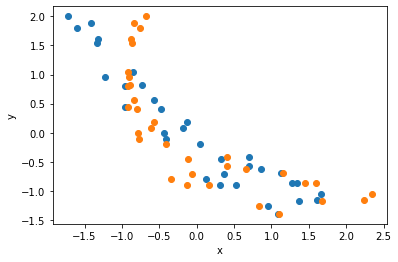

In [20]:
x_1p = np.vstack([x_1**i for i in range(1, order + 1)]) # 2 stacks for now. 
x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True) #z-score.
y_1s = (y_1 - y_1.mean()) / y_1.std() # z-score
plt.scatter(x_1s[0], y_1s) # plot the first order
plt.scatter(x_1s[1], y_1s) # second order. 
plt.xlabel('x')
plt.ylabel('y')

In [21]:
# first linear
with pm.Model() as model_l: 
    
    # priors
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = 2) #2 predictors?
    ϵ = pm.HalfNormal('ϵ', 2)
    
    # linear model
    μ = pm.Deterministic('μ', α + β * x_1s[0]) 
    
    # likelihood
    y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)
    
    # sample 
    trace_l = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


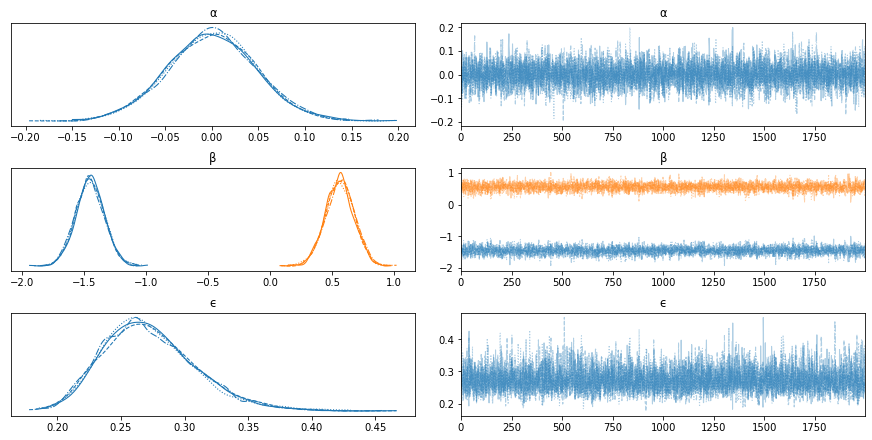

In [22]:
# second order term: 
with pm.Model() as model_p: 
    
    # priors
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = 2, shape = order) #2 predictors?
    ϵ = pm.HalfNormal('ϵ', 2)
    
    # linear model
    μ = α + pm.math.dot(β, x_1s) 
    
    # likelihood
    y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)
    
    # sample 
    trace_p = pm.sample(2000)
    
    # plot trace
    az.plot_trace(trace_p)

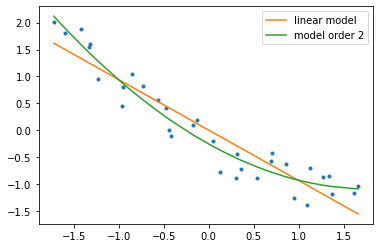

In [23]:
## linear model
# plot some nice stuff
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

# mean alpha
α_l_post = trace_l['α'].mean()

# mean beta?
β_l_post = trace_l['β'].mean(axis = 0)

# model post for each
y_l_post = α_l_post + β_l_post * x_new

plt.plot(x_new, y_l_post, 'C1', label = 'linear model')

## quadratic
α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis = 0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', 
        label = f'model order {order}')

x_new_p = np.vstack([x_new**i for i in range(1, order + 1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p)

plt.scatter(x_1s[0], y_1s, c = 'C0', marker = ".")
plt.legend()

In [24]:
# posterior predictions
y_l = pm.sample_posterior_predictive(trace_l, 2000, 
                                    model = model_l)['y']
y_p = pm.sample_posterior_predictive(trace_p, 2000,
                                    model = model_p)['y']

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


([], [])

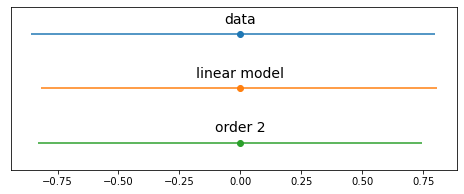

In [25]:
# IQR visualization
# both models slightly over-confident.
plt.figure(figsize = (8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data): 
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr = [[-err[0]], [err[1]]], fmt = 'o')
    plt.text(mean, -i + 0.2, labels[i], ha = 'center', fontsize = 14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

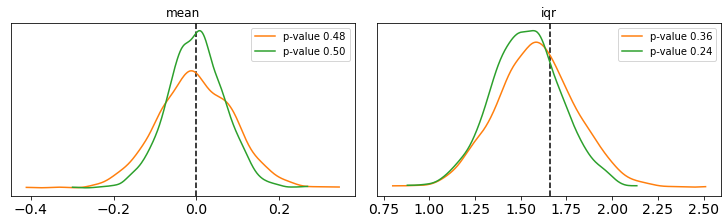

In [26]:
# dispersion
fig, ax = plt.subplots(1, 2, figsize = (10, 3), constrained_layout = True)

def iqr(x, a = 0):
    return np.subtract(*np.percentile(x, [75, 25], axis = a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color = 'k', ls = '--')
    
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs = {'color': c},
                   label = f'p-value {p_value:.2f}',
                   ax = ax[idx])
        ax[idx].set_title(func.__name__)
        ax[idx].set_yticks([])
        ax[idx].legend()

Text(0, 0.5, 'y')

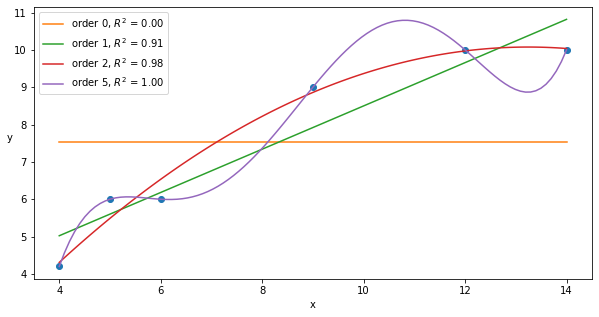

In [27]:
# least squares (basically flat prior)
x = np.array([4, 5, 6, 9, 12, 14])
y = np.array([4.2, 6, 6, 9, 10, 10])

plt.figure(figsize = (10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg = i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat - ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    
    plt.plot(x_n, ffit, label = f'order {i}, $R^2$ = {r2:.2f}')

plt.legend(loc = 2)
plt.xlabel('x')
plt.ylabel('y', rotation = 0)

In [14]:
# this seems to have changed. 
# so his measure is our times minus two..
# this affects Estimate (which is half and negative for us) and SE which is just half. 
waic_l = az.waic(trace_l)
waic_l

Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.33     2.70
p_waic        2.45        -

In [30]:
# LOO baseline, but can also compute WAIC.
# waic: again, follows same pattern.
# pwaic: number of parameters (corresponds).
# d_waic: relative diff (half for us). 
# SE: actually opposite here compared to his somehow. 
# dse: always 0 for the top-ranked model. 
cmp_df = az.compare({'model_l': trace_l,
                   'model_p': trace_p},
                    method = 'stacking',
                   ic = "waic")
cmp_df

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_p,0,-4.507717,2.572099,0.000000,1.000000e+00,2.326709,0.000000,False,log
model_l,1,-14.369162,2.457420,9.861445,1.012523e-13,2.677697,2.637252,False,log


<AxesSubplot:xlabel='Log'>

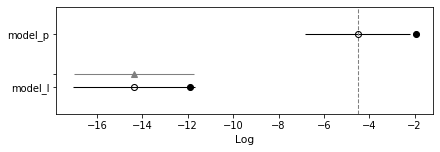

In [31]:
# so we get this flipped as well. 
az.plot_compare(cmp_df)

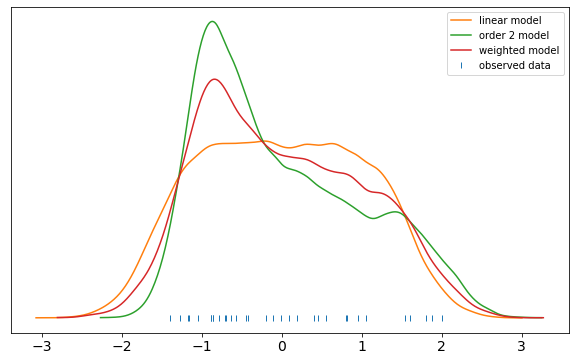

In [32]:
# weighted posterior predictive sample
w = 0.5 #weight them equally?
y_lp = pm.sample_posterior_predictive_w(
    [trace_l, trace_p],
    samples = 1000,
    models = [model_l, model_p],
    weights = [w, 1-w])

_, ax = plt.subplots(figsize = (10, 6))
az.plot_kde(y_l, plot_kwargs = {'color': 'C1'},
           label = 'linear model', ax = ax)
az.plot_kde(y_p, plot_kwargs = {'color': 'C2'},
           label = 'order 2 model', ax = ax)
az.plot_kde(y_lp['y'], plot_kwargs = {'color': 'C3'},
           label = 'weighted model', ax = ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label = 'observed data')
plt.yticks([])
plt.legend()

## Bayes Factor

In [33]:
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

In [34]:
# could this be done with tensor instead of math?
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p = p)
    
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    
    # a priori
    θ = pm.Beta('θ', m[0], m[1])
    
    # likelihood
    y = pm.Bernoulli('y', θ, observed = y_d)
    
    trace_BF = pm.sample(5000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.880653031890107, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

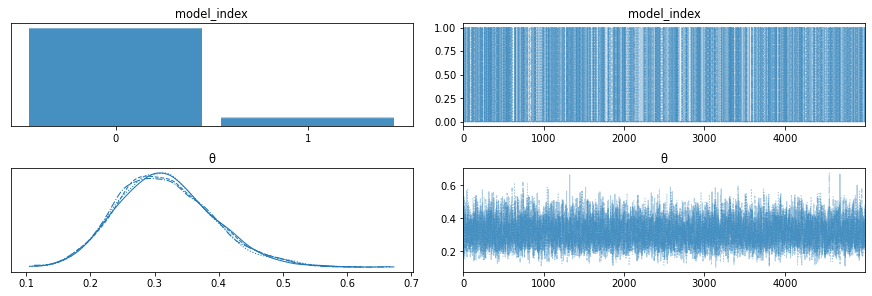

In [36]:
az.plot_trace(trace_BF)

# Sequential Monte Carlo (SMC)

In [35]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed = y_d)
    trace_BF_0 = pm.sample_smc(2500)
    
with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed = y_d)
    trace_BF_1 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.207
Stage:   1 Beta: 0.670
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.206
Stage:   1 Beta: 0.677
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.210
Stage:   1 Beta: 0.686
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.208
Stage:   1 Beta: 0.666
Stage:   2 Beta: 1.000


In [38]:
# compute bayes factor. 
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1 
BF = (pM0 / pM1) * (p[1] / p[0])
BF

11.706480304955527

In [44]:
# model.marginal_likelihood deprecated it seems. 
# why do we get more than one thing?
# anyways.. the numbers are sort of reasonable. 
BF_smc = np.exp(trace_BF_0.report.log_marginal_likelihood - trace_BF_1.report.log_marginal_likelihood)
np.round(BF_smc, decimals = 2)

array([11.4 , 10.99, 11.07, 11.49])

# Bayes factor & IC

In [74]:
tracesGG = []
waics = []
models = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed = y_d)
            trace = pm.sample(2000)
            tracesGG.append(trace)
            waics.append(az.waic(trace))
            models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.88950826798152, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793398467031961, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

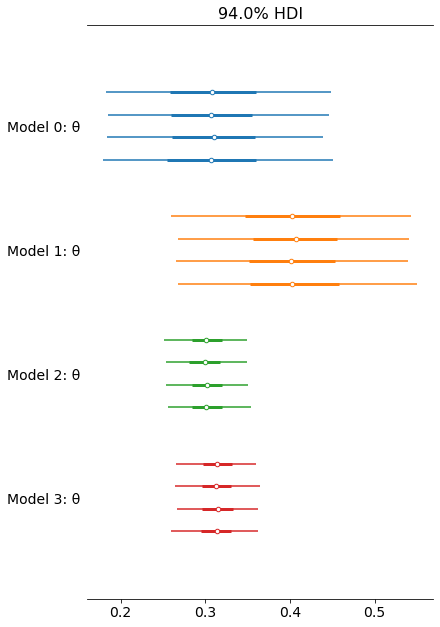

In [82]:
az.plot_forest(tracesGG, combined = False)

IndexError: list index out of range

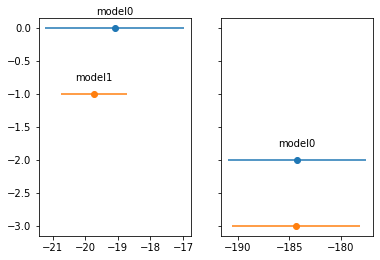

In [79]:
#what should be model_names?
fig, ax = plt.subplots(1, 2, sharey = True)

#labels = ['model0', 'model0-1', 'model1', 'model1-1']
#labels = ['1', '2', '3', '4']
labels = ['model0', 'model1', 'model0']

indices = [0, 0, 1, 1]

for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr = d.waic_se, fmt = 'o')
    ax[ind].text(mean, -i + 0.2, labels[i], ha = 'center')
    
ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace = 0.05)
fig.text(0.5, 0, 'Deviance', ha = 'center', fontsize = 14)

# Regularizing priors

In [ ]:
# ridge regression
# lasso regression

# Entropy

In [63]:
from scipy import stats

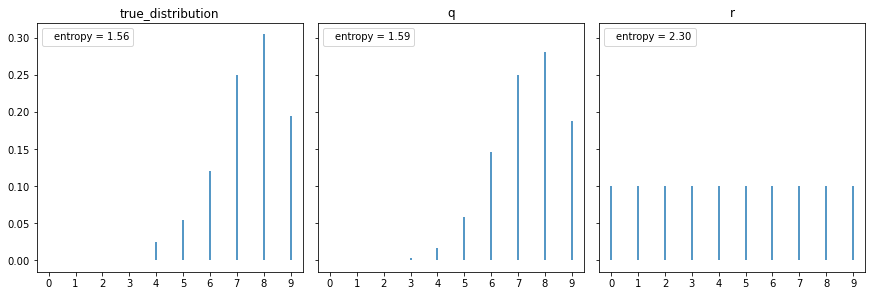

In [85]:
# what is wrong with r?
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)
true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]
q_pmf = q.pmf(x)
r_pmf = r.pmf(x)
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf],
                                        ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

In [86]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution, r_pmf)

(0.009657896086383405, 0.7394593875511319)

# Exercises

## E1:
This exercise is about regularization priors. In the code that generates the data,
change order=2 to another value, such as order=5. Then, fit model_p and plot
the resulting curve. Repeat this, but now using a prior for beta with sd=100
instead of sd=1 and plot the resulting curve. How are both curves different? Try
this out with sd=np.array([10, 0.1, 0.1, 0.1, 0.1]), too.

In [87]:
# from earlier
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]


In [68]:
# second order term: 
traces = []
models = []

for order in [2, 5]: 
    x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
    x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
    y_1s = (y_1 - y_1.mean()) / y_1.std()
    for beta_sd in [1, 100]: 
        with pm.Model() as model: 

            # priors
            α = pm.Normal('α', mu = 0, sd = 5)
            β = pm.Normal('β', mu = 0, sd = beta_sd, shape = order) 
            ϵ = pm.HalfNormal('ϵ', 2)

            # linear model
            #μ = pm.Deterministic('μ', α + β[0] * x_1s[0] + β[1] * x_1s[1]) 
            μ = α + pm.math.dot(β, x_1s) 

            # likelihood
            y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)

            # sample 
            trace = pm.sample(2000, cores = 1)
            
            # append
            traces.append(trace)
            models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 66 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 294 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

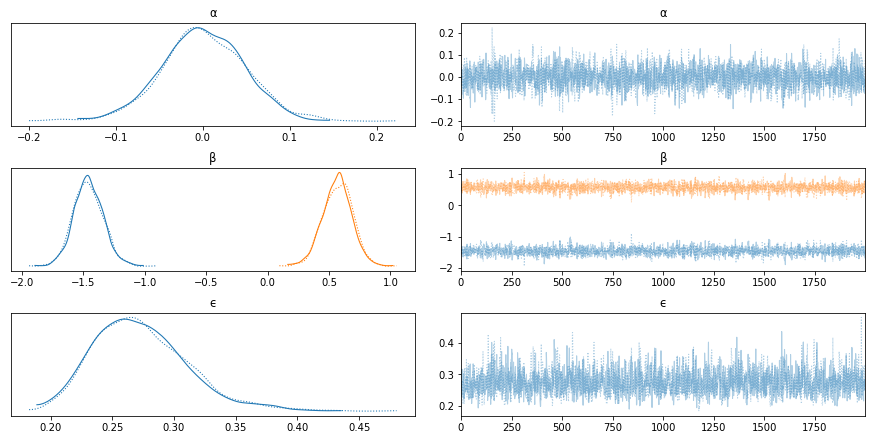

In [93]:
# first the two with order = 5
az.plot_trace(traces[1])

In [88]:
order = 5
x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

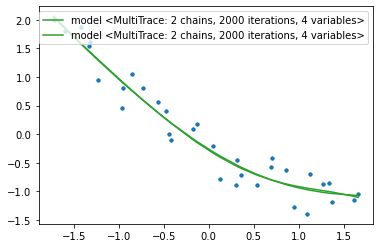

In [89]:
# first some linspace
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
order = 5

# then a loop 
for trace in traces[2:]: # the last two. 
    α_post = trace['α'].mean()
    β_post = trace['β'].mean(axis = 0)
    idx = np.argsort(x_1s[0]) #has to be the right one.. 
    y_post = α_post + np.dot(β_post, x_1s)
    
    plt.plot(x_1s[0][idx], y_post[idx], 'C2', label = f'model {trace}')
    
    x_new_p = np.vstack([x_new**i for i in range(1, order + 1)]) #need to know order..
    y_p_post = α_p_post + np.dot(β_post, x_new_p)

    plt.scatter(x_1s[0], y_1s, c = 'C0', marker = ".")
    plt.legend()
    

In [94]:
# then with order = 2
order = 2
x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

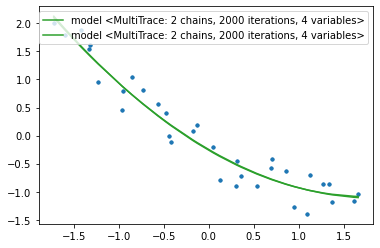

In [95]:
# first some linspace
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

# then a loop 
for trace in traces[:2]: # the last two. 
    α_post = trace['α'].mean()
    β_post = trace['β'].mean(axis = 0)
    idx = np.argsort(x_1s[0]) #has to be the right one.. 
    y_post = α_post + np.dot(β_post, x_1s)
    
    plt.plot(x_1s[0][idx], y_post[idx], 'C2', label = f'model {trace}')
    
    x_new_p = np.vstack([x_new**i for i in range(1, order + 1)]) #need to know order..
    y_p_post = α_p_post + np.dot(β_post, x_new_p)

    plt.scatter(x_1s[0], y_1s, c = 'C0', marker = ".")
    plt.legend()

In [ ]:
# interrim: 
# SD does not really matter for the order = 2 polynomial.
# SD does matter for order = 5 polynomial.
# too high SD and it cannot properly fit. 

In [96]:
# now trying with sd = np.array([10, 0.1, 0.1, 0.1, 0.1])
# guess we just tell it that we think that for the first beta it could vary more..
# second order term: 
order = 5
x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
beta_sd = np.array([10, 0.1, 0.1, 0.1, 0.1])

with pm.Model() as E1model_p: 

    # priors
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = beta_sd, shape = order) 
    ϵ = pm.HalfNormal('ϵ', 2)

    # linear model
    μ = α + pm.math.dot(β, x_1s) 

    # likelihood
    y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)

    # sample 
    trace = pm.sample(2000, cores = 1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

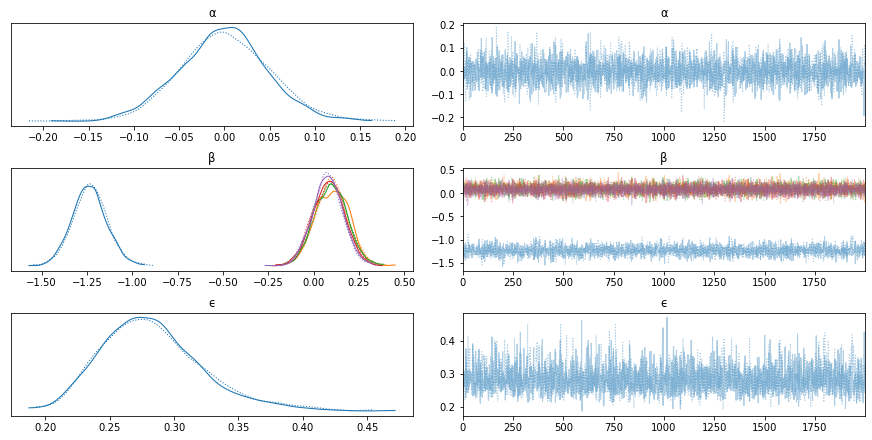

In [97]:
az.plot_trace(trace) #much better fit.

## E2:
Repeat the previous exercise but increase the amount of data to 500 data points.

In [98]:
# from earlier
dummy_data = np.loadtxt('../data/dummy.csv')
dummy_data = np.concatenate([dummy_data] * 15)
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

In [99]:
# running models again
# second order term: 
traces2 = []

for order in [2, 5]: 
    x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
    x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
    y_1s = (y_1 - y_1.mean()) / y_1.std()
    for beta_sd in [1, 100]: 
        with pm.Model() as E1model_p: 

            # priors
            α = pm.Normal('α', mu = 0, sd = 5)
            β = pm.Normal('β', mu = 0, sd = beta_sd, shape = order) 
            ϵ = pm.HalfNormal('ϵ', 2)

            # linear model
            μ = α + pm.math.dot(β, x_1s) 

            # likelihood
            y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)

            # sample 
            trace = pm.sample(2000)
            
            # append
            traces2.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


C:\Anaconda\envs\bayes\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda\envs\bayes\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 77 seconds.
There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7194671260565564, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ϵ, β, α]


Sampling 1 chain for 183 tune and 0 draw iterations (183 + 0 draws total) took 3 seconds.
No posterior samples. Unable to run convergence checks


In [ ]:
# not sure the fit is actually that much better?

## E3:
Fit a cubic model (order 3), compute WAIC and LOO, plot the results, and
compare them with the linear and quadratic models.

In [100]:
# load data again:
# from earlier
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

In [107]:
# first, second, third order
traces3 = []
waics3 = []
models3 = []
for order in [1, 2, 3]:
    x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
    x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
    y_1s = (y_1 - y_1.mean()) / y_1.std()
    with pm.Model() as model: 

        # priors
        α = pm.Normal('α', mu = 0, sd = 5)
        β = pm.Normal('β', mu = 0, sd = 2, shape = order) #2 predictors?
        ϵ = pm.HalfNormal('ϵ', 2)

        # linear model
        #μ = pm.Deterministic('μ', α + β[0] * x_1s[0] + β[1] * x_1s[1]) 
        μ = α + pm.math.dot(β, x_1s) 

        # likelihood
        y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)

        # sample 
        trace = pm.sample(2000)
        
        # append stuff
        waics3.append(az.waic(trace))
        traces3.append(trace)
        models3.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [114]:
# WAIC comparison. 
# order 2 is best. 
cmp_df = az.compare({'linear': traces3[0],
                     'order 2': traces[1],
                     'order 3': traces3[2]},
                    method = 'stacking')
cmp_df

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
order 2,0,-4.614345,2.663171,0.000000,1.000000e+00,2.335828,0.000000,False,log
order 3,1,-5.452183,3.350020,0.837838,3.087808e-15,2.377022,0.382515,False,log
linear,2,-14.410105,2.480893,9.795760,5.551115e-16,2.682287,2.667860,False,log


<AxesSubplot:xlabel='Log'>

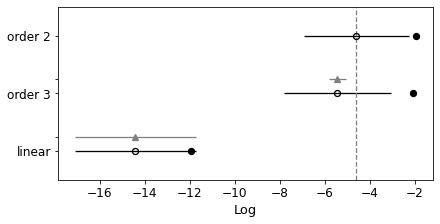

In [115]:
az.plot_compare(cmp_df)

In [116]:
# load data again:
# from earlier
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

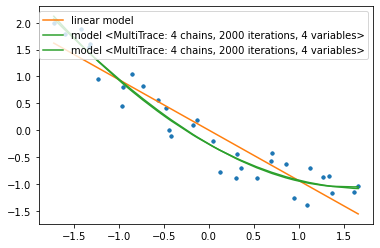

In [117]:
# plot them.
# first some linspace
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

# for the linear
# mean alpha
α_l_post = traces3[0]['α'].mean()

# mean beta?
β_l_post = traces3[0]['β'].mean(axis = 0)

# model post for each
y_l_post = α_l_post + β_l_post * x_new

plt.plot(x_new, y_l_post, 'C1', label = 'linear model')

# then a loop 
for order, trace in enumerate(traces3[1:]): # deselect the first one
    
    # preprocessing
    x_1p = np.vstack([x_1**i for i in range(1, order + 3)])
    x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
    y_1s = (y_1 - y_1.mean()) / y_1.std()

    α_post = trace['α'].mean()
    β_post = trace['β'].mean(axis = 0)
    
    idx = np.argsort(x_1s[0]) #has to be the right one.. 
    y_post = α_post + np.dot(β_post, x_1s)
    
    plt.plot(x_1s[0][idx], y_post[idx], 'C2', label = f'model {trace}')
    
    x_new_p = np.vstack([x_new**i for i in range(1, order + 3)]) #need to know order..
    y_p_post = α_p_post + np.dot(β_post, x_new_p)

    plt.scatter(x_1s[0], y_1s, c = 'C0', marker = ".")
    plt.legend()

In [ ]:
# makes sense that the second order would be better than third order
# since their fit is almost exactly the same. 

## E4:
Use pm.sample_posterior_predictive() to rerun the PPC example, but this
time, plot the values of y instead of the values of the mean. <br/>
NB: What PPC example does he mean?

In [118]:
# load data again:
# from earlier
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8787205108574011, but should be close to 0.8. Try to increase the number of tuning steps.


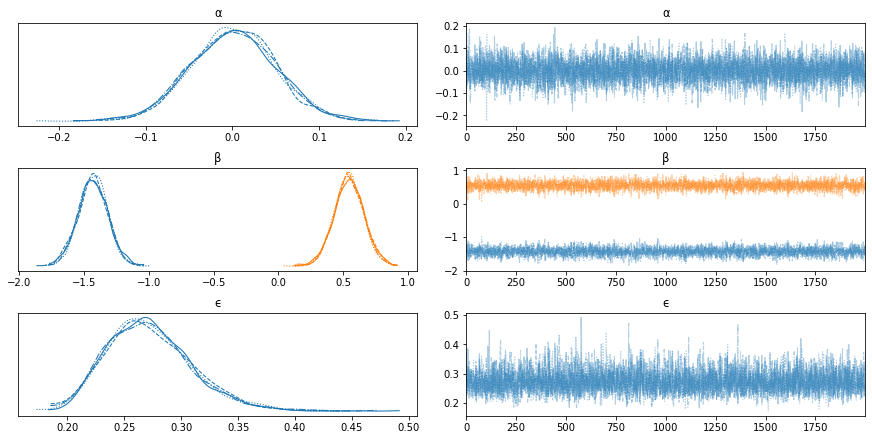

In [120]:
# running model "l" and model "p"
# preprocessing
order = 1
x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

with pm.Model() as model_l: 
    
    # priors
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = 1) 
    ϵ = pm.HalfNormal('ϵ', 2)
    
    # linear model
    μ = pm.Deterministic('μ', α + β * x_1s[0]) 
    
    # likelihood
    y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)
    
    # sample 
    trace_l = pm.sample(2000)


# preprocessing
order = 2
x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
x_1s = (x_1p - x_1p.mean(axis = 1, keepdims = True)) / x_1p.std(axis = 1, keepdims = True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

with pm.Model() as model_p: 
    
    # priors
    α = pm.Normal('α', mu = 0, sd = 5)
    β = pm.Normal('β', mu = 0, sd = 1, shape = order) #2 predictors?
    ϵ = pm.HalfNormal('ϵ', 2)
    
    # linear model
    μ = α + pm.math.dot(β, x_1s) 
    
    # likelihood
    y = pm.Normal('y', mu = μ, sd = ϵ, observed = y_1s)
    
    # sample 
    trace_p = pm.sample(2000)
    
    # plot trace
    az.plot_trace(trace_p)

In [145]:
# posterior predictions
y_l = pm.sample_posterior_predictive(trace_l, 100, 
                                    model = model_l,
                                    var_names = ['y'])
y_p = pm.sample_posterior_predictive(trace_p, 100,
                                    model = model_p,
                                    var_names = ['y'])

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:xlabel='y'>

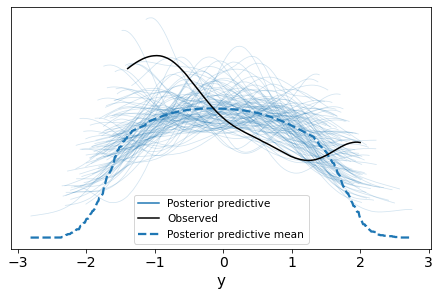

In [146]:
az.plot_ppc(az.from_pymc3(posterior_predictive = y_l, model = model_l))

<AxesSubplot:xlabel='y'>

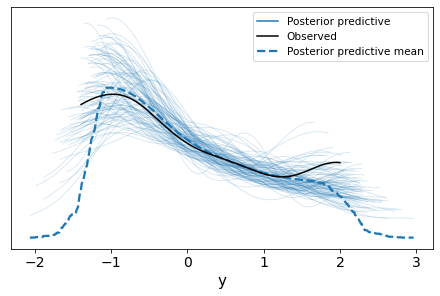

In [147]:
az.plot_ppc(az.from_pymc3(posterior_predictive = y_p, model = model_p))

([], [])

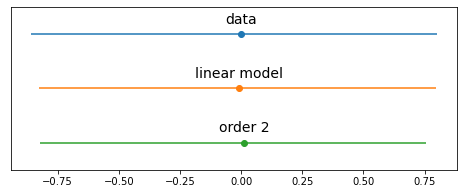

In [153]:
# IQR visualization
plt.figure(figsize = (8, 3))
data = [y_1s, y_l['y'], y_p['y']]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data): 
    mean = d.mean() #what to do instead here?
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr = [[-err[0]], [err[1]]], fmt = 'o')
    plt.text(mean, -i + 0.2, labels[i], ha = 'center', fontsize = 14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

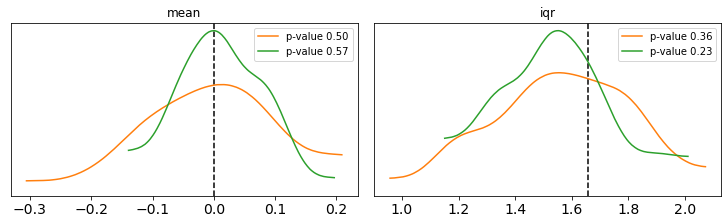

In [155]:
# dispersion
fig, ax = plt.subplots(1, 2, figsize = (10, 3), constrained_layout = True)

def iqr(x, a = 0):
    return np.subtract(*np.percentile(x, [75, 25], axis = a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color = 'k', ls = '--')
    
    for d_sim, c in zip([y_l['y'], y_p['y']], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs = {'color': c},
                   label = f'p-value {p_value:.2f}',
                   ax = ax[idx])
        ax[idx].set_title(func.__name__)
        ax[idx].set_yticks([])
        ax[idx].legend()

# E5
Read and run the posterior predictive example from PyMC3's documentation at
https://docs.pymc.io/notebooks/posterior_predictive.html

In [156]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [158]:
data = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)

    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.


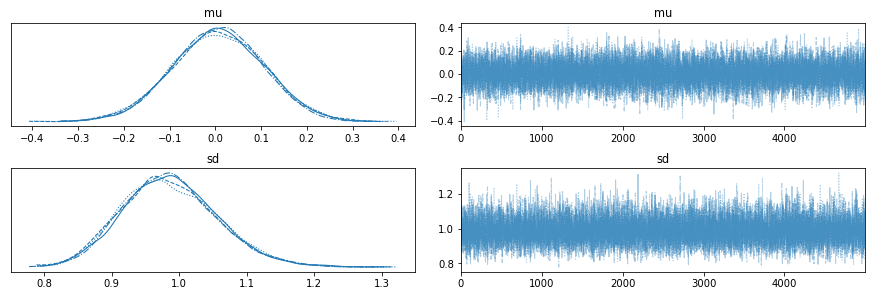

In [161]:
az.plot_trace(trace);

In [162]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model, size=100)

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [163]:
np.asarray(ppc['n']).shape

(500, 100, 100)

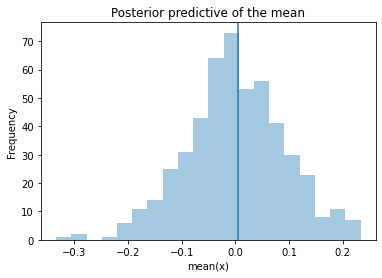

In [164]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc['n']], kde=False, ax=ax)
ax.axvline(data.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [165]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [166]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

n = 4000
n_oos = 50
coeff = 1.

predictors = np.random.normal(size=n)
# Turn predictor into a shared var so that we can change it later
predictors_shared = shared(predictors)

outcomes = np.random.binomial(1, invlogit(coeff * predictors))

In [167]:
outcomes

array([0, 1, 1, ..., 1, 1, 0])

In [168]:
predictors_oos = np.random.normal(size=50)
outcomes_oos = np.random.binomial(1, invlogit(coeff * predictors_oos))

In [170]:
def tinvlogit(x):
    import theano.tensor as t
    return t.exp(x) / (1 + t.exp(x))

with pm.Model() as model:
    coeff = pm.Normal('coeff', mu=0, sd=1)
    p = tinvlogit(coeff * predictors_shared)

    o = pm.Bernoulli('o', p, observed=outcomes)

    trace = pm.sample(5000, n_init=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeff]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 59 seconds.


In [171]:
# Changing values here will also change values in the model
predictors_shared.set_value(predictors_oos)

In [172]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_posterior_predictive(trace, model=model, samples=500)

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Text(0, 0.5, 'outcome')

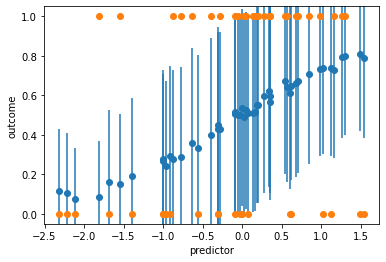

In [173]:
plt.errorbar(x=predictors_oos, y=np.asarray(ppc['o']).mean(axis=0), yerr=np.asarray(ppc['o']).std(axis=0), linestyle='', marker='o')
plt.plot(predictors_oos, outcomes_oos, 'o')
plt.ylim(-.05, 1.05)
plt.xlabel('predictor')
plt.ylabel('outcome')

# E6
Go back to the code that generated Figure 5.5 and Figure 5.6, and modify it to get
new sets of six data points. Visually evaluate how the different polynomials fit
these new datasets. Relate the results to the discussions in this book

Text(0, 0.5, 'y')

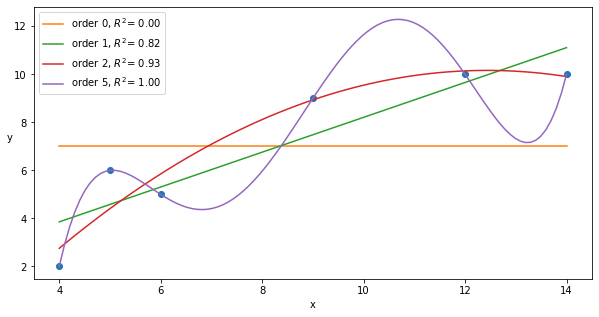

In [174]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([2, 6., 5., 9., 10, 10.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

Not sure whether there is so much to say. 
We know that the order 5 polynomial will always fit six points perfectly,
because it has six degrees of freedom (the intercept as well). 
It has very high variance and learns too much from the data.
The order 1 might have slightly too much bias (learns to little),
but it is much more useful than the order 5 polynomial.
From an information theory perspective the order 5 polynomial
does not do any compression of information and as such just codes
the information in a new (but uncompressed) format. It has not 
learned anything from the data. 

# 7. E7
Read and run the model averaging example from PyMC3's documentation at
https:/​/​docs.​pymc.​io/​notebooks/​model_​averaging.​html

In [175]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

In [176]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [177]:
d = pd.read_csv(
    "https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/milk.csv",
    sep=";",)

d = d[["kcal.per.g", "neocortex.perc", "mass"]].rename({"neocortex.perc": "neocortex"}, axis=1)
d["log_mass"] = np.log(d["mass"])
d = d[~d.isna().any(axis=1)].drop("mass", axis=1)
d.iloc[:, 1:] = d.iloc[:, 1:] - d.iloc[:, 1:].mean()
d.head()

,kcal.per.g,neocortex,log_mass
0,0.49,-12.415882,-0.831486
5,0.47,-3.035882,0.158913
6,0.56,-3.035882,0.181513
7,0.89,0.064118,-0.579032
9,0.92,1.274118,-1.884978


In [178]:
with pm.Model() as neo: 
    
    # priors
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 10)
    sigma = pm.HalfNormal('sigma', 10)
    
    # likelihood 
    μ = α + β * d["neocortex"]
    
    # y
    kcal = pm.Normal('kcal', mu = μ, sigma = sigma, observed = d["kcal.per.g"])
    
    # trace
    neo_trace = pm.sample(2000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [179]:
with pm.Model() as mass: 
    
    # priors
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 1)
    sigma = pm.HalfNormal('sigma', 10)
    
    # likelihood 
    μ = α + β * d["log_mass"]
    
    # y
    kcal = pm.Normal('kcal', mu = μ, sigma = sigma, observed = d["kcal.per.g"])
    
    # trace
    mass_trace = pm.sample(2000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.


In [182]:
with pm.Model() as two_pred:
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", 10)

    mu = α + pm.math.dot(β, d[["neocortex", "log_mass"]].T) #.T = transposed?

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    double_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


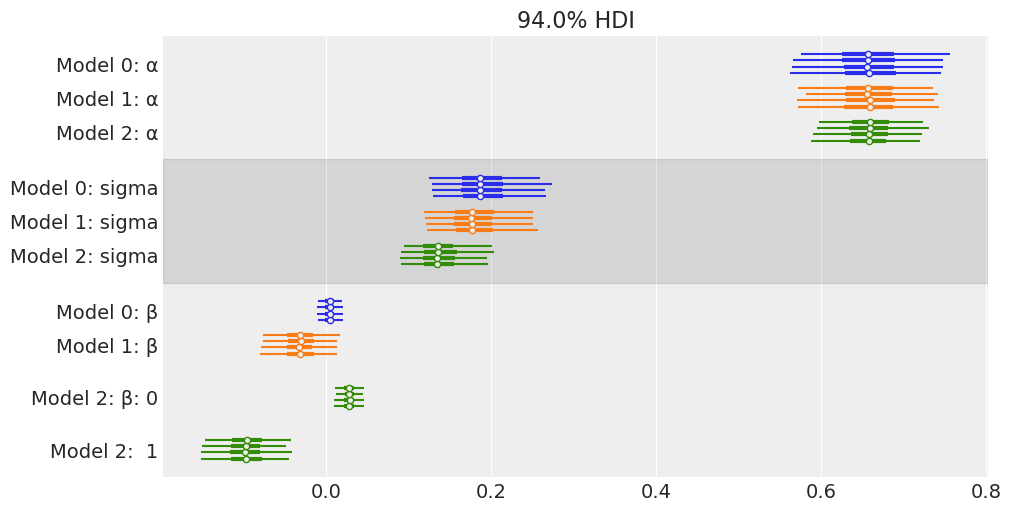

In [184]:
traces = [neo_trace, mass_trace, double_trace]
az.plot_forest(traces, figsize=(10, 5));

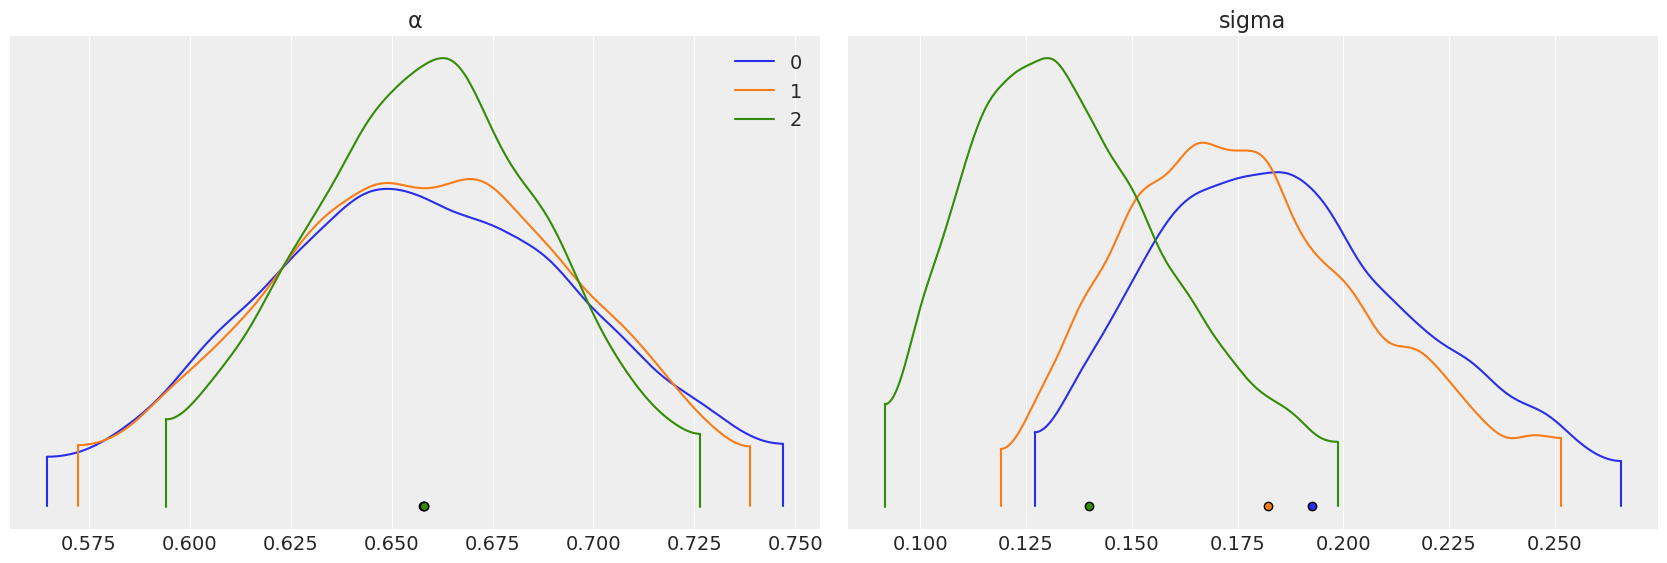

In [185]:
az.plot_density(traces, var_names=["α", "sigma"]);

In [190]:
model_dict = dict(zip(["neo", "mass", "two_pred"], traces))
comp = az.compare(model_dict, method = "BB-pseudo-BMA")
comp

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_pred,0,8.117380,3.365996,0.000000,0.888448,1.587787,0.000000,False,log
mass,1,4.378314,2.114708,3.739065,0.051635,2.082283,1.765806,False,log
neo,2,3.540339,1.992191,4.577041,0.059917,2.525118,2.526040,False,log


In [191]:
# will this still work with ascending = True now that the names are different??
ppc_w = pm.sample_posterior_predictive_w(
    traces,
    1000,
    [neo, mass, two_pred],
    weights=comp.weight.sort_index(ascending=True),
    progressbar=True,
)

In [192]:
ppc_2 = pm.sample_posterior_predictive(double_trace, 1000, two_pred, progressbar=False)

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


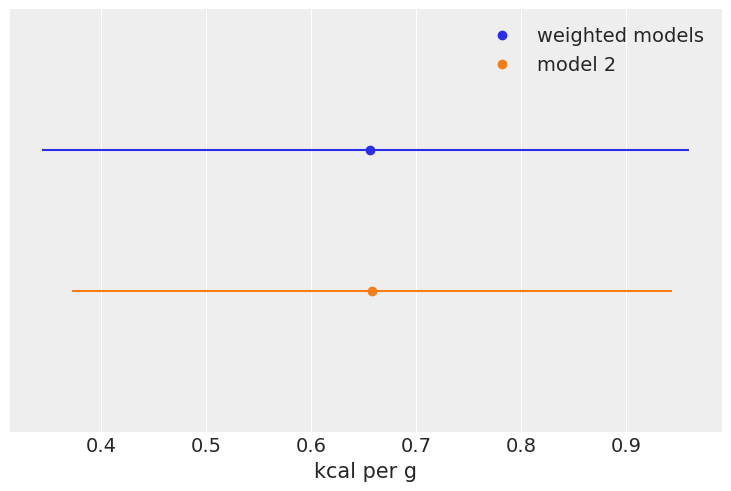

In [193]:
# comparing
# I get somewhat less difference than they do.
mean_w = ppc_w["kcal"].mean()
hpd_w = az.hdi(ppc_w["kcal"]).mean(0)

mean = ppc_2["kcal"].mean()
hpd = az.hdi(ppc_2["kcal"]).mean(0)

plt.plot(mean_w, 1, "C0o", label="weighted models")
plt.hlines(1, *hpd_w, "C0")
plt.plot(mean, 0, "C1o", label="model 2")
plt.hlines(0, *hpd, "C1")

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel("kcal per g")
plt.legend();

# E8
Compute the Bayes factor for the coin problem using a uniform prior beta (1, 1)
and priors such as beta (0.5, 0.5). Set 15 heads and 30 coins. Compare this result
with the inference we got in the first chapter of this book.

In [194]:
# balanced coins
coins = 30
heads = 15
y_d = np.repeat([0, 1], [coins-heads, heads])

In [195]:
# could this be done with tensor instead of math?
with pm.Model() as m1:
    θ = pm.Beta('θ', 1, 1) #uniform I think. 
    y = pm.Bernoulli('y', θ, observed = y_d)
    t1 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.359
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.333
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.334
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.336
Stage:   1 Beta: 1.000


In [196]:
with pm.Model() as m2:
    θ = pm.Beta('θ', 0.5, 0.5) #convex (so bad..)
    y = pm.Bernoulli('y', θ, observed = y_d)
    t2 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.154
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.143
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.136
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.140
Stage:   1 Beta: 1.000


In [197]:
# marginal likelihood appears to have changed also. 
# not sure why there are two numbers: but both are close to the 11 mentioned in the book. 
BF_smc = np.exp(t1.report.log_marginal_likelihood - t2.report.log_marginal_likelihood)
BF_smc

array([1.50661706, 1.59602387, 1.5466999 , 1.54228494])

In [ ]:
# so... does this mean that model 1 is twice as good as model 2?

In [200]:
w1 = az.waic(t1)
w2 = az.waic(t2)

In [201]:
waics = []
waics.append(w1)
waics.append(w2)

In [207]:
?az.compare

In [210]:
# Model 1 has all the weight. 
model_dict = dict(zip(["m1", "m2"], [t1, t2]))
comp = az.compare(model_dict, method = "BB-pseudo-BMA", ic = "waic")
comp

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m1,0,-21.769411,0.974995,0.000000,0.505211,0.000872,0.000000,False,log
m2,1,-21.790255,0.995838,0.020844,0.494789,0.001371,0.000505,False,log


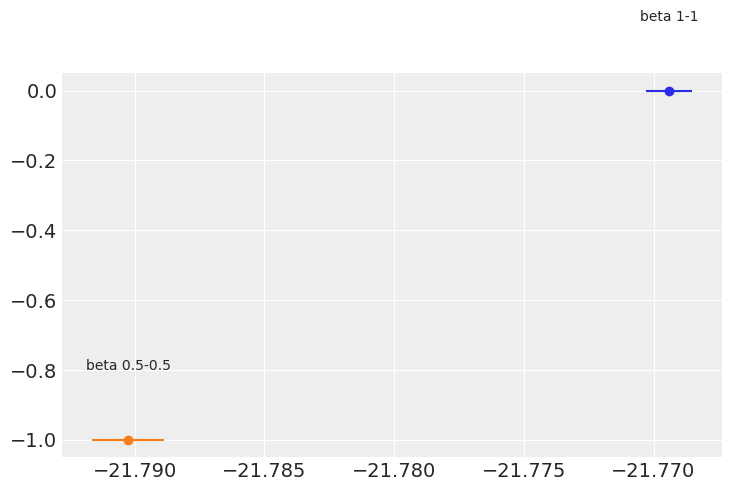

In [204]:
fig, ax = plt.subplots()

labels = ['beta 1-1', 'beta 0.5-0.5']
indices = [0, 1]

for i, (ind, d) in enumerate(zip(indices, waics)): 
    mean = d.waic
    ax.errorbar(mean, -i, xerr = d.waic_se, fmt = 'o')
    ax.text(mean, -i + 0.2, labels[i], ha = 'center')

In [81]:
# not sure what we got in chapter 1. 
# I would assume that we found that the 
# likelihood (data) was enough to overpower the prior
# as such the posterior inference should be roughly
# the same. However, bayes factor (as we know) 
# depends on the prior (because the marginal likelihood does).

# E9:
Repeat the last example where we compare Bayes factors and Information
Criteria, but now reduce the sample size.

In [231]:
# balanced coins (smaller sampel size)
coins = 4
heads = 2
y_d = np.repeat([0, 1], [coins-heads, heads])

In [232]:
# could this be done with tensor instead of math?
with pm.Model() as m1:
    θ = pm.Beta('θ', 1, 1) #uniform I think. 
    y = pm.Bernoulli('y', θ, observed = y_d)
    t1 = pm.sample_smc(2500)
    
with pm.Model() as m2:
    θ = pm.Beta('θ', 0.5, 0.5) #convex (so bad..)
    y = pm.Bernoulli('y', θ, observed = y_d)
    t2 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000


In [233]:
# now I get two different things - need to find out why this is the case. 
BF_smc = np.exp(t1.report.log_marginal_likelihood - t2.report.log_marginal_likelihood)
BF_smc # just two similar estimates I guess. 

array([1.51550317, 1.46074333, 1.44417938, 1.4078176 ])

In [234]:
# model 1 still has all the weight
model_dict = dict(zip(["m1", "m2"], [t1, t2]))
comp = az.compare(model_dict, method = "BB-pseudo-BMA")
comp

C:\Anaconda\envs\bayes\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m1,0,-3.674867,0.902264,0.000000,0.565002,0.006854,0.000000,False,log
m2,1,-3.936815,1.164155,0.261948,0.434998,0.027035,0.022712,False,log


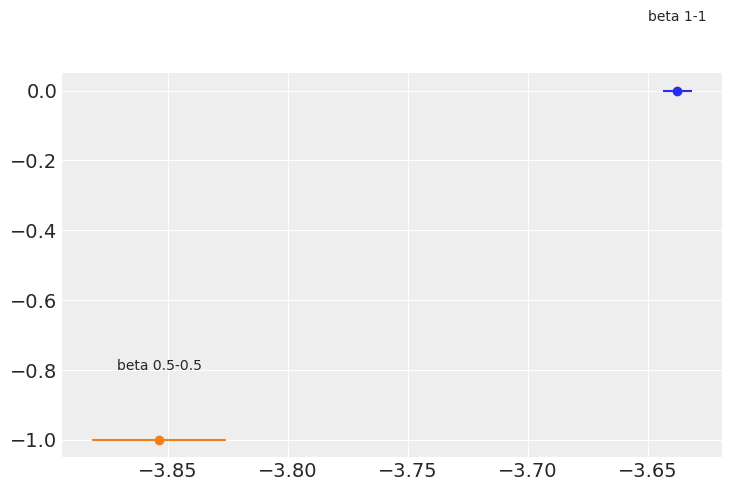

In [235]:
# relative diff seems the same, but they are both ?more? uncertain.
waics = []
waics.append(az.waic(t1))
waics.append(az.waic(t2))

fig, ax = plt.subplots()

labels = ['beta 1-1', 'beta 0.5-0.5']
indices = [0, 1]

for i, (ind, d) in enumerate(zip(indices, waics)): 
    mean = d.waic
    ax.errorbar(mean, -i, xerr = d.waic_se, fmt = 'o')
    ax.text(mean, -i + 0.2, labels[i], ha = 'center')

# E10
For the entropy example, change the q distribution. Try this with distributions
like stats.binom(10, 0.5) and stats.binom(10, 0.25).

In [236]:
from scipy import stats

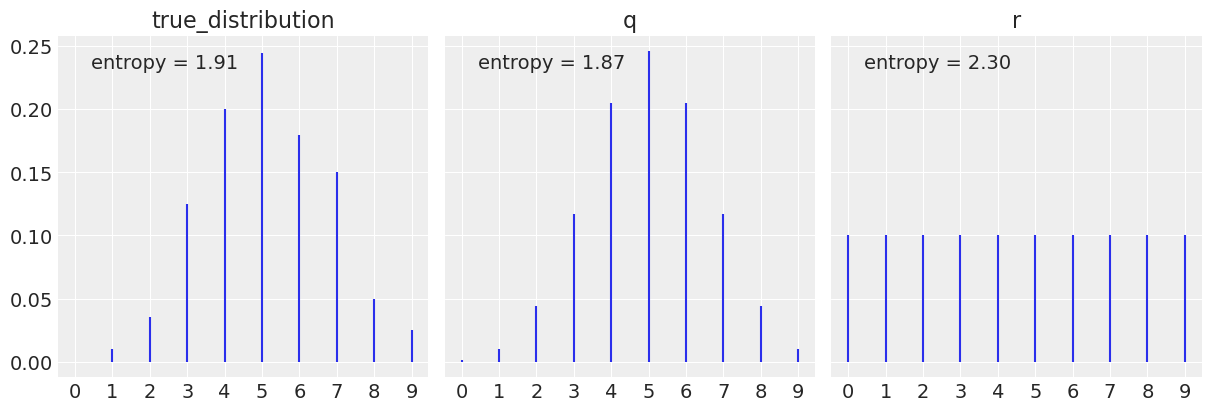

In [241]:
# what is wrong with r?
np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.50)
r = stats.randint(0, 10)
true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]
q_pmf = q.pmf(x)
r_pmf = r.pmf(x)
_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf],
                                        ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

In [242]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution, r_pmf)

(0.016217792067861888, 0.39549243995662253)

In [247]:
# making it into a function
def plot_dist(q_prob):
    
    np.random.seed(912)
    x = range(0, 10)
    q = stats.binom(10, q_prob)
    r = stats.randint(0, 10)
    true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]
    q_pmf = q.pmf(x)
    r_pmf = r.pmf(x)
    _, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,constrained_layout=True)

    for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf],
                                            ['true_distribution', 'q', 'r'])):
        ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
        ax[idx].set_title(label)
        ax[idx].set_xticks(x)
        ax[idx].legend(loc=2, handlelength=0)

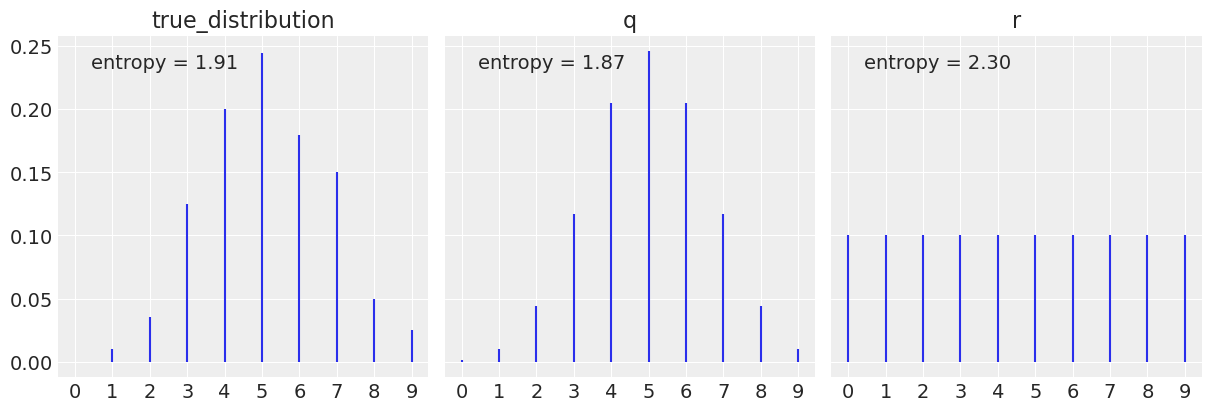

In [249]:
plot_dist(0.5)